In [19]:
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

from paittern.contouring import data
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2

In [6]:
import os

In [3]:
path_to_file = "../raw_data/people_segmentation"
X,Y = data.get_XY(path_to_file)

In [ ]:
#%%time
#X_train, y_train, X_test, y_test = data.copy_split_data(X, Y, path='data2/')

In [20]:
X_train = [cv2.imread(filename) for filename in sorted(glob(os.path.join("data2","train","X","*.png")))]

In [23]:
y_train = [cv2.imread(filename) for filename in sorted(glob(os.path.join("data2","train","y","*.png")))]

In [25]:
np.unique(y_train[3])

array([  0, 255], dtype=uint8)

In [26]:
new_X, new_y = data.resized_images(X_train, y_train, (128,128))

In [27]:
new_X = np.array(new_X)
new_y = np.array(new_y)

In [28]:
new_y2 = new_y.mean(axis=3)

new_y2 = np.expand_dims(new_y2, axis = -1)

new_y2 = new_y2/255

In [29]:
new_X.shape, new_y2.shape

((4542, 128, 128, 3), (4542, 128, 128, 1))

In [ ]:
def plot_img_mask(number):
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    ax1.imshow(new_X[number])
    ax2.imshow(new_y[number])
    plt.show()

In [30]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

2022-03-01 17:41:19.451054: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [32]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [33]:
def show_predictions(X, y):
    for image, mask in zip(X,y):
        image = np.expand_dims(image, axis = 0)
        pred_mask = model.predict(image)
    fig, [ax1, ax2, ax3] = plt.subplots(3,1)
    ax1.imshow(image[0])
    ax2.imshow(mask[0])
    ax3.imshow(create_mask(pred_mask))

In [34]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [35]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
EPOCHS = 20
VAL_SUBSPLITS = 5

model_history = model.fit(new_X, new_y2, 
                          epochs=EPOCHS,
                          validation_split=0.2, verbose = 1)

Epoch 1/20
114/114 [==============================] - 116s 998ms/step - loss: 0.4396 - accuracy: 0.7999 - val_loss: 1.3482 - val_accuracy: 0.5045
Epoch 2/20
114/114 [==============================] - 109s 953ms/step - loss: 0.3585 - accuracy: 0.8385 - val_loss: 0.4160 - val_accuracy: 0.8058
Epoch 3/20
114/114 [==============================] - 104s 916ms/step - loss: 0.3449 - accuracy: 0.8454 - val_loss: 0.3736 - val_accuracy: 0.8298
Epoch 4/20
114/114 [==============================] - 103s 909ms/step - loss: 0.3334 - accuracy: 0.8517 - val_loss: 0.3561 - val_accuracy: 0.8401
Epoch 5/20
114/114 [==============================] - 103s 904ms/step - loss: 0.3263 - accuracy: 0.8547 - val_loss: 0.3700 - val_accuracy: 0.8295
Epoch 6/20
114/114 [==============================] - 103s 899ms/step - loss: 0.3207 - accuracy: 0.8578 - val_loss: 0.3567 - val_accuracy: 0.8407
Epoch 7/20
114/114 [==============================] - 101s 891ms/step - loss: 0.3139 - accuracy: 0.8607 - val_loss: 0.3492 -

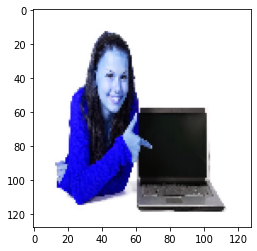

In [55]:
k=1
to_test = np.expand_dims(new_X[k], axis=0)
y_pred = model.predict(to_test)

plt.imshow(new_X[k])

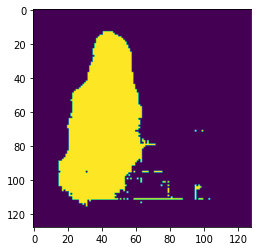

In [56]:
plt.imshow(create_mask(y_pred))